Following: https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/

In [1]:
import os
print(os.listdir("../input"))

['flickr8k', 'extractedfeaturesdescriptionflickr8k', 'na-attempt-1']


## Prepare Photo Data

Let's create a function to extract features from all images. This function would be called to prepare photo data for testing the model. Later we save rge resulting dictionary to a file named 'features.pkl'

In [2]:
#Import libraries
from numpy import array

from os import listdir
from pickle import dump, load
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

import string

Using TensorFlow backend.


In [3]:
# Extract features from each photo in the directory
def extract_features(directory):
    #load the model
    model = VGG16()
    #re-structure the model
    model.layers.pop()
    model = Model(inputs = model.inputs, outputs = model.layers[-1].output)
    #summarize
    print(model.summary())
    #extract features from each photo
    features = dict()
    for name in listdir(directory):
        #load an image from the file 
        filename = directory + '/' + name
        image = load_img(filename, target_size = (224, 224))
        #convert the image pixels to a numpy array
        image = img_to_array(image)
        #reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        #prepare the image for the VGG model
        image = preprocess_input(image)
        #get features
        feature = model.predict(image, verbose = 0)
        #get image id
        image_id = name.split('.')[0]
        #store features
        features[image_id] = feature
        print('>%s' %name)
    return features

In [ ]:
### THIS CHUNK IS NOT WORKING ---> SO I AM GOING TO USE THE FEATURES FILE THAT I HAD UPLOADED

#Let's put this all together
#Extract features from all the images
#directory = '../input/flickr8k/flickr8k_dataset/Flicker8k_Dataset'
#features = extract_features(directory)
#print('Extracted Features: %d' % len(features))
# save to file
#dump(features, open('features.pkl', 'wb'))

With this, all the features of the images have been extracted

So, since the chunk above didn't work I have run this on my PC and saved the output features files in kaggle to use. Later in the code you'd see that I refer to folder __extractedfeaturesdescriptionflickr8k__ that I had shared with the team to use the features and description file.

## Prepare Text Data

In [4]:
#Load the file containing all of the descriptions

def load_doc(filename):
    #open the file as read only
    file = open(filename, 'r')
    #read all text
    text = file.read()
    #close the file
    file.close()
    return text

filename = '../input/flickr8k/flickr8k_text/Flickr8k.token.txt'
#load descriptions 
doc = load_doc(filename)

In [5]:
#extract descriptions for images
def load_descriptions(doc):
    mapping = dict()
    #process lines
    for line in doc.split('\n'):
        #slit line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        #take the first token as the image id, the rest as a description
        image_id, image_desc = tokens[0], tokens[1:]
        #remove filename extension from image id
        image_id = image_id.split('.')[0]
        #convert descrption tokens back to string
        image_desc = ' '.join(image_desc)
        #create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        #store description
        mapping[image_id].append(image_desc)
    return mapping

#parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


Next, let's clean the text. Perforrming the necessary tasks of text mining:
- converting words to lowercase
- removing all the punctuations
- removing all the words that are 1 character or less in length
- remove all words with numbers in them

In [6]:

def clean_descriptions(descriptions):
    #prepare translation table for removing the punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            #tokenize
            desc = desc.split()
            #convert to lower case
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove 1 character words 
            desc = [word for word in desc if len(word) > 1]
            #remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            #store as a string
            desc_list[i] = ' '.join(desc)
        
#clean descriptions
clean_descriptions(descriptions)

Next, we summarize the size of the vocabulary.

In [7]:
#convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    #build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

#summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' %len(vocabulary))

Vocabulary Size: 8763


In [8]:
#save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

#save descriptions to the file
save_descriptions(descriptions, 'descriptions.txt')

## Developing Deep Learning Model

### LOAD DATA

In [9]:
#load doc into memory
#use the function load_doc defines above

#load a pre-defines list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        #skip empty lines
        if len(line) < 1:
            continue
        #get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

Function __load_clean_descriptions()__ defined below loads the cleaned text descriptions from ‘descriptions.txt‘ for a given set of identifiers and returns a dictionary of identifiers to lists of text descriptions

Using  strings __startseq__ and __endseq__ for first-word and last word signal purpose. These tokens are added to the loaded descriptions as they are loaded. It is important to do this now before we encode the text so that the tokens are also encoded correctly.

In [10]:
#load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    #load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        #split line by whitespace
        tokens = line.split()
        #split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        #skip images not in set
        if image_id in dataset:
            #create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            #wrap description in tokens
            desc = 'startseq' + ' '.join(image_desc) + ' endseq'
            #store
            descriptions[image_id].append(desc)
    return descriptions

In [11]:
#load photo features
def load_photo_features(filename, dataset):
    #load all features
    all_features = load(open(filename, 'rb'))
    #filter features
    features = {k: all_features[k] for k in dataset}
    return features

In [12]:
#load training dataset (6K)
filename = '../input/flickr8k/flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' %len(train))
#descriptions
train_descriptions = load_clean_descriptions('../input/extractedfeaturesdescriptionflickr8k/descriptions.txt', train)
print('Descriptions: train = %d' %len(train_descriptions))
#photo features
train_features = load_photo_features('../input/extractedfeaturesdescriptionflickr8k/features.pkl', train)
print('Photos: train = %d' %len(train_features))

Dataset: 6000
Descriptions: train = 6000
Photos: train = 6000


The description text will need to be encoded to numbers before it can be presented to the model as in input or compared to the model’s predictions

In [13]:

#convert a dictionary of clean descriptions to a list of descreptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

#prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' %vocab_size)

Vocabulary Size: 8306


In [14]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos):
    X1, X2, y = list(), list(), list()
    # walk through each image identifier
    for key, desc_list in descriptions.items():
        # walk through each description for the image
        for desc in desc_list:
            # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # store
                X1.append(photos[key][0])
                X2.append(in_seq)
                y.append(out_seq)
    return array(X1), array(X2), array(y)

In [15]:
# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

### DEFINING THE MODEL

In [16]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    # plot_model(model, to_file='model.png', show_shapes = True)
    return model

In [17]:
# train dataset
 
# load training dataset (6K)
filename = '../input/flickr8k/flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('../input/extractedfeaturesdescriptionflickr8k/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('../input/extractedfeaturesdescriptionflickr8k/features.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 8306
Description Length: 33


DONOT RUN THE NEXT TWO CHUNKS, AS IT THROWS A MEMORY ERROR

In [ ]:
### DO NOT RUN
# prepare sequences
#X1train, X2train, ytrain = create_sequences(tokenizer, 10, train_descriptions, train_features)

In [ ]:
## DO NOT RUN
# dev dataset
 
# load test set
#filename = '../input/flickr8k/flickr8k_text/Flickr_8k.devImages.txt'
#test = load_set(filename)
#print('Dataset: %d' % len(test))
# descriptions
#test_descriptions = load_clean_descriptions('../input/extractedfeaturesdescriptionflickr8k/descriptions.txt', test)
#print('Descriptions: test=%d' % len(test_descriptions))
# photo features
#test_features = load_photo_features('../input/extractedfeaturesdescriptionflickr8k/features.pkl', test)
#print('Photos: test=%d' % len(test_features))
# prepare sequences
#X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features)
 

### FITTING THE MODEL

In [18]:
# define the model
model = define_model(vocab_size, max_length)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 33)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 33, 256)      2126336     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)  

In [19]:
# define checkpoint callback
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

In [ ]:
## DONOT RUN THIS CHUNK
# fit model
#model.fit([X1train, X2train], ytrain, epochs=20, verbose=2, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))

### Train With Progressive Loading

In [20]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length):
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            # retrieve the photo feature
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo)
            yield [[in_img, in_seq], out_word]

You can see that we are calling the create_sequence() function to create a batch worth of data for a single photo rather than an entire dataset. This means that we must update the create_sequences() function to delete the “iterate over all descriptions” for-loop.

The updated function is as follows:

In [21]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

In [22]:
#`max_length = 33

In [ ]:
# test the data generator
generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
inputs, outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

In [ ]:
# train the model, run epochs manually and save after each epoch
epochs = 20
steps = len(train_descriptions)
for i in range(epochs):
    # create the data generator
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    # fit for one epoch
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    # save model
    model.save('model_' + str(i) + '.h5')

### Evaluate Model

In [23]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [24]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU scores are used in text translation for evaluating translated text against one or more reference translations.

Here, we compare each generated description against all of the reference descriptions for the photograph. We then calculate BLEU scores for 1, 2, 3 and 4 cumulative n-grams.

In [25]:
# prepare tokenizer on train set
 
# load training dataset (6K)
filename = '../input/flickr8k/flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('../input/extractedfeaturesdescriptionflickr8k/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
#max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)
 
# prepare test set
 
# load test set
filename = '../input/flickr8k/flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('../input/extractedfeaturesdescriptionflickr8k/descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('../input/extractedfeaturesdescriptionflickr8k/features.pkl', test)
print('Photos: test=%d' % len(test_features))
 


Dataset: 6000
Descriptions: train=6000
Vocabulary Size: 8306
Description Length: 33
Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [29]:
from keras.models import load_model
from numpy import argmax
from nltk.translate.bleu_score import corpus_bleu

# load the model
filename = '../input/na-attempt-1/model_19.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.393931
BLEU-2: 0.178722
BLEU-3: 0.115938
BLEU-4: 0.046588


### Generate New Captions

In [30]:
from keras.preprocessing.text import Tokenizer
from pickle import dump

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# load training dataset (6K)
filename = '../input/flickr8k/flickr8k_text/Flickr_8k.testImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

Dataset: 1000
Descriptions: train=1000


In [51]:

# load the tokenizer
#tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 33
# load the model
model = load_model('../input/na-attempt-1/model_19.h5')
# load and prepare the photograph
photoFilename = '../input/flickr8k/flickr8k_dataset/Flicker8k_Dataset/1015118661_980735411b.jpg'
photo = extract_features(photoFilename)
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

startseq clipped by curly startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq


Populating the interactive namespace from numpy and matplotlib


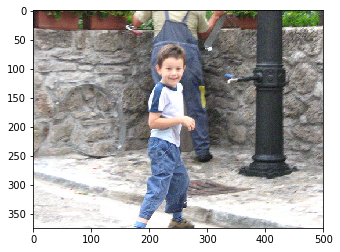

In [52]:

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(photoFilename)
imgplot = plt.imshow(img)
plt.show()



### Generate New Captions